# Modeling - Target: Covid 'death_rate'

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly  # used plotly graphing library for maps
import plotly.express as px
import plotly.graph_objects as go 

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import (RandomForestRegressor,
                              AdaBoostRegressor,
                              GradientBoostingRegressor,
                              VotingRegressor)
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

### Functions

In [2]:
def print_gs(gs, X_train, X_test, y_train, y_test):
    """
    Takes gridsearch model and the data and prints the best cross val score, 
    the associated cross val range (std * 2), the test score, and the best
    parameters.
    :param gs: Fit gridsearch model.
    :param X_train: X_train used for the model.
    :param X_test: X_test used for the model.
    :param y_train: y_train used for the model.
    :param y_test: y_test used for the model.
    :return: None
    """
    results = gs.cv_results_
    cv_mean = gs.cv_results_['mean_test_score'][gs.best_index_]
    cv_range = 2 * gs.cv_results_['std_test_score'][gs.best_index_]
    print(f'Cross Val Score {cv_mean} +/- {cv_range}')
    print('Test Score: ', gs.score(X_test, y_test))
    print('Best Params: ', gs.best_params_)
    
    
def rmse_gs(gs, baseline):
    """
    Takes a fit grid search model, calculates the rmse, and prints the
    baseline rmse, the model rmse, and the improvement.
    :param gs: Fit gridsearch model. 
    :param baseline: The baseline rmse.
    :return: None
    """
    preds = gs.predict(X_test)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, preds))
    print('Baseline RMSE: ', round(baseline, 5))
    print('Model RMSE:    ', round(rmse, 5))
    print(f'Improvement:    {round(baseline - rmse, 5)}')

**Set Random Seed**

In [3]:
random_state=42
np.random.seed(random_state)

### Import Data

In [4]:
df = pd.read_csv('../data/cleaned_merged_df.csv', index_col=0)

## Feature Selection
**Feature importances to use in Random Forest death rate model**

In [5]:
X = df._get_numeric_data().drop(columns=['death_rate', 
                                         'deaths', 
                                         'gini_index'])
y = df['death_rate']
X_train, X_test, y_train, y_test = train_test_split(X, y)
        
        #scale data
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)
        
        #fit random forest regressor
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
        #get feature importances
feature_names = [f'feature {i}' for i in range(X.shape[1])]

result = permutation_importance(rf, X_train, y_train, 
                                n_repeats=10, 
                                n_jobs=-1)
        #create dataframe
forest_importances = pd.Series(result.importances_mean, index=feature_names)
feature_df = pd.DataFrame(columns = ['index'])
feature_df['forest_importances'] = forest_importances
feature_df.drop(columns=['index'], inplace=True)
features = list(X.T.index)
feature_df['feature'] = features
        #sort by top 20

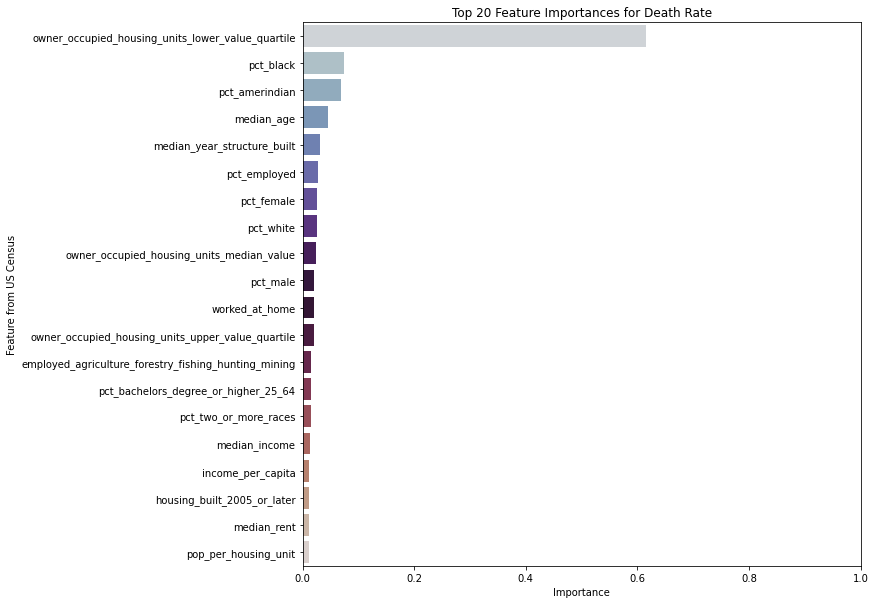

In [6]:
top_20 = feature_df.sort_values(by='forest_importances', 
                                ascending=False).head(20)

#bar plot for sorted importances
plt.figure(figsize=(10, 10))
sns.barplot(x=top_20['forest_importances'], y=top_20['feature'],
           palette='twilight')

plt.xticks(ticks=[0, .2, .4, .6, .8, 1.0])

plt.xlabel('Importance')
plt.ylabel('Feature from US Census')
plt.title('Top 20 Feature Importances for Death Rate');

## Models

**Pipelines for Modeling**

In [7]:
pipe_lr = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LinearRegression())
])

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=random_state))
])

pipe_ada = Pipeline([
    ('ss', StandardScaler()),
    ('ada', AdaBoostRegressor(random_state=random_state))
])

pipe_gb = Pipeline([
    ('ss', StandardScaler()),
    ('gb', GradientBoostingRegressor(random_state=random_state))
])

**Filter Data & Train Test Split**

In [8]:
features = [col for col in top_20['feature']]

X = df[features]
y = df['death_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y)

**Baseline**

In [9]:
preds_base = np.ones(X_test.shape[0]) * np.mean(y_test)
baseline_rmse = np.sqrt(metrics.mean_squared_error(y_test, preds_base))
baseline_rmse

0.008926002669090032

**Interpretation:** The RMSE is 0.00858 for the baseline model which is where the predictions are the mean of the true values.

**Linear Regression**

In [10]:
gs_lr = GridSearchCV(pipe_lr, param_grid={})
gs_lr.fit(X_train, y_train)
print_gs(gs_lr, X_train, X_test, y_train, y_test)

Cross Val Score 0.2718068822958372 +/- 0.07151345279497492
Test Score:  0.2463087343998882
Best Params:  {}


**Interpretation:** The test score is much lower than the cross validation score which indicates that the model is overfit. Additionally, the low scores indicate that the model is biased.

In [11]:
rmse_gs(gs_lr, baseline_rmse)

Baseline RMSE:  0.00893
Model RMSE:     0.00775
Improvement:    0.00118


**Random Forest Regressor**

In [12]:
params_rf = {
    'rf__n_estimators': [200, 300],
    'rf__max_depth': [5, 10, 15]
}

gs_rf = GridSearchCV(pipe_rf, param_grid=params_rf, n_jobs=-1)
gs_rf.fit(X_train, y_train)
print_gs(gs_rf, X_train, X_test, y_train, y_test)

Cross Val Score 0.35160718164706634 +/- 0.04693301125329616
Test Score:  0.3575423946787575
Best Params:  {'rf__max_depth': 15, 'rf__n_estimators': 300}


**Interpretation:** As the cross validation score is lower than the test score the model is not overfit, however, low score indicates that the model is biased.

In [13]:
rmse_gs(gs_rf, baseline_rmse)

Baseline RMSE:  0.00893
Model RMSE:     0.00715
Improvement:    0.00177


**Ada Boost Regressor**

In [14]:
params_ada = {
    'ada__base_estimator': [RandomForestRegressor(max_depth=3,
                                                  min_samples_leaf=10,
                                                  min_samples_split=10,
                                                  n_estimators=75,
                                                  random_state=random_state)],
    'ada__learning_rate': [0.001]
}

gs_ada = GridSearchCV(pipe_ada, param_grid=params_ada, n_jobs=-1)
gs_ada.fit(X_train, y_train)
print_gs(gs_ada, X_train, X_test, y_train, y_test)

Cross Val Score 0.27121971872871475 +/- 0.05342995597541469
Test Score:  0.25947460025054614
Best Params:  {'ada__base_estimator': RandomForestRegressor(max_depth=3, min_samples_leaf=10, min_samples_split=10,
                      n_estimators=75, random_state=42), 'ada__learning_rate': 0.001}


**Interpretation:** The ada boost regressor's cross val score is higher than the test score indicating that the model is overfit. Additionally, the low score indicates a large bias.

In [15]:
rmse_gs(gs_ada, baseline_rmse)

Baseline RMSE:  0.00893
Model RMSE:     0.00768
Improvement:    0.00124


**Gradient Boosting Regressor**

In [16]:
params_gb = {
    'gb__learning_rate': [0.001, 0.01, 0.1],
    'gb__n_estimators': [300, 500, 1_000],
    'gb__max_depth': [5, 7, 10]
}

gs_gb = GridSearchCV(pipe_gb, param_grid=params_gb, n_jobs=-1)
gs_gb.fit(X_train, y_train)
print_gs(gs_gb, X_train, X_test, y_train, y_test)

Cross Val Score 0.34751653987028197 +/- 0.04573013900808408
Test Score:  0.35183112040192943
Best Params:  {'gb__learning_rate': 0.01, 'gb__max_depth': 5, 'gb__n_estimators': 1000}


**Interpretation:** The gradient boosting regressor is not overfit as the cross val score is lower than the test score, however, the low score indicates that the model is biased.

In [17]:
rmse_gs(gs_gb, baseline_rmse)

Baseline RMSE:  0.00893
Model RMSE:     0.00719
Improvement:    0.00174


**Voting Regressor**

In [18]:
vote = VotingRegressor([
    ('rf', pipe_rf),
    ('gb', pipe_gb)
])

params_vote = {
    'rf__rf__max_depth': [15],
    'rf__rf__n_estimators': [200, 300],
    'gb__gb__learning_rate': [0.001, 0.01],
    'gb__gb__n_estimators': [500, 1_000],
    'gb__gb__max_depth': [5, 7, 10]
}

gs_vote = GridSearchCV(vote,
                      param_grid=params_vote,
                      n_jobs=-1)
gs_vote.fit(X_train, y_train)
print_gs(gs_vote, X_train, X_test, y_train, y_test)

Cross Val Score 0.3596772082727179 +/- 0.04760577126862348
Test Score:  0.3642262108365024
Best Params:  {'gb__gb__learning_rate': 0.01, 'gb__gb__max_depth': 5, 'gb__gb__n_estimators': 1000, 'rf__rf__max_depth': 15, 'rf__rf__n_estimators': 300}


**Interpretation:** The voting regressor model is not overfit as the cross val score is lower than the test score. The low score indicates that the model is biased.

In [19]:
rmse_gs(gs_vote, baseline_rmse)

Baseline RMSE:  0.00893
Model RMSE:     0.00712
Improvement:    0.00181


### Model & Scores Table

|model|rsme|test score|cross val mean|cross val std*2|
| ---:                        | :---:   | :---: | :---: | :---: |
| Baseline                    | 0.00893 | -     | -     | -     |
| Linear Regression           | 0.00775 | 0.246 | 0.272 | 0.072 |
| Random Forest Regressor     | 0.00715 | 0.358 | 0.352 | 0.047 |
| Ada Boost Regressor         | 0.00768 | 0.259 | 0.271 | 0.053 |
| Gradient Boosting Regressor | 0.00719 | 0.352 | 0.348 | 0.046 |
| Voting Regressor            | 0.00712 | 0.364 | 0.360 | 0.048 

### Model Selection & Results
We decided to go with the Voting Regressor as our model as it was not overfit and has the higest r2 score and smallest cross validation standard deviation.

**Plotting Predicted vs Actual**

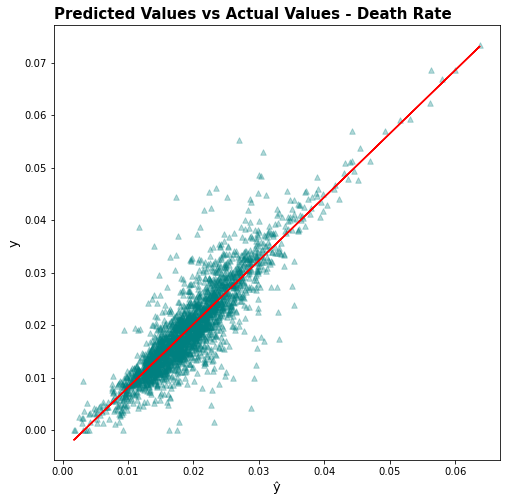

R2 Score:  0.3642262108365024


In [23]:
graph_pred  =  gs_vote.predict(X)
score       =  gs_vote.score(X_test, y_test)

plt.figure(figsize=(8,8))
plt.scatter(graph_pred, y,
           s = 30,
           color = 'teal',
           marker = '^',
           alpha=0.3)

plt.title('Predicted Values vs Actual Values - Death Rate',
          loc='left', fontweight='bold', fontsize=15)
plt.xlabel('ŷ', size=13)
plt.ylabel('y', size=13)

m, b = np.polyfit(graph_pred, y, 1)

plt.plot(graph_pred, m*graph_pred+b, color='red')

plt.show()

print("R2 Score: ", score)

**Interpretation:** The scatter plot above shows predicted covid death rates vs actual covid death rates. The graph shows that the model, at times, may be off by up to 0.03 in it's prediction, which is quite a lot as the death rates only range from 0 to 0.06. The model is not great but it shows that the selected features show at least some signal.

**Feature Importances**

In [45]:
importances = gs_rf.best_estimator_.named_steps['rf'].feature_importances_
model_features = pd.DataFrame(data=importances, 
                              columns=['importance'],
                              index=X_test.columns)

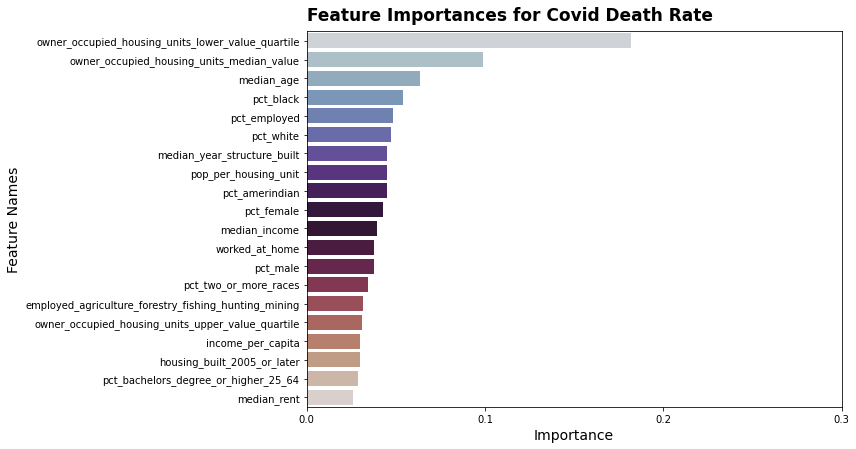

In [46]:
model_features = model_features.sort_values(by='importance', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=model_features['importance'], y=model_features.index,
           palette='twilight')

plt.xticks(ticks=[0, .1, .2, .3])

plt.xlabel('Importance', size=14)
plt.ylabel('Feature Names', size=14)
plt.tight_layout()
plt.savefig('../img/gb_feature_importances_death_rate.png')
# dont want title in the slides
plt.title('Feature Importances for Covid Death Rate',
          loc='left', fontweight='bold', fontsize=17, pad=11);

**Interpretation:** The bar plot above shows the feature importances pulled from the Random Forest Regressor Model, which was used in the Voting Regressor. The owner_occupied_housing_units_lower_value_quartile is the feature that has the highest importance with a steep decrease in importance for the next highest feature. Noticeably, the chart does not include poverty_rate, however, there are similar columns such as median_income, and income_per_capita.